## Import all dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as ToTensor
import torchvision.transforms as Lambda
import torchvision.datasets as ImageFolder
import torch.utils.data as DataLoader
import torch.utils.data as Dataset
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
from torchsummary import summary
from PIL import Image

## Clear Cache

In [ ]:
torch.cuda.empty_cache()

## Fetch Stanford dog images

In [2]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2024-02-17 12:46:55--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  17.2MB/s    in 58s     

2024-02-17 12:47:53 (13.1 MB/s) - ‘images.tar’ saved [793579520/793579520]



## Extract images folder

In [3]:
!rm -r dataset
!mkdir dataset
!tar -xf images.tar -C ./dataset
!mv ./dataset/Images ./dataset/dogs
dog_list = os.listdir('dataset/dogs')
print(dog_list[:5],'...')
!wget https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt

rm: cannot remove 'dataset': No such file or directory
['n02088466-bloodhound', 'n02108551-Tibetan_mastiff', 'n02096294-Australian_terrier', 'n02110627-affenpinscher', 'n02096051-Airedale'] ...
--2024-02-17 12:48:10--  https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31675 (31K) [text/plain]
Saving to: ‘synset_words.txt’

synset_words.txt    100%[===================>]  30.93K  --.-KB/s    in 0s      

2024-02-17 12:48:11 (117 MB/s) - ‘synset_words.txt’ saved [31675/31675]



## Setting

In [4]:
# Directory path 
image_dir = "./dataset/dogs/"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

# Hyperparameters (Set some contants...)
RANDOM_SEED = 0
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
NUM_EPOCHS_ft = 25
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)

# Fixed Parameters
N_CHANNELS = 3
NUMBER_CLASSES = 120

## Creating Custom Dataset
Note: Passing the modification on the datasets

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, image_transform = None, label_transform = None, train: bool = True):
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.train = train
        self.images, self.labels = self.creatdataset(file_path)
        # self.class_names = {}

    def creatdataset(self, file_path):
        list_images = []
        list_labels = []
        num_sample_train = 12000
        for index, subfolder in enumerate(os.listdir(image_dir)):
            dogname = subfolder[subfolder.index('-') + 1:]
            ID = subfolder.split('-')[0]
            # self.class_names[index] = dogname
            for image in os.listdir(os.path.join(file_path, subfolder)):
                if ((Image.open(os.path.join(file_path, subfolder, image)).getbands() == ("R", "G", "B")) and (image.endswith('.jpg'))):
                   list_images.append((os.path.join(file_path, subfolder, image)))
                   list_labels.append(index)

        random.seed(0)
        indexes_train = random.sample(range(len(list_images)), num_sample_train)

        if self.train:
           list_images = [list_images[i] for i in indexes_train]
           list_labels = [list_labels[i] for i in indexes_train]
        else:
            list_images = [list_images[i] for i in range(len(list_images)) if i not in indexes_train]
            list_labels = [list_labels[i] for i in range(len(list_labels)) if i not in indexes_train]

        return list_images, list_labels


    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):
        image = Image.open(self.images[index])
        label = self.labels[index]

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

## Calculate mean and std values of train dataset

In [6]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = CustomDataset(image_dir, image_transform = transform, label_transform = None, train=True)
train_ldr = torch.utils.data.DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True)

In [7]:
mean = torch.zeros(3)
std = torch.zeros(3)

for inputs, _labels in train_ldr:
    for i in range(N_CHANNELS):
        mean[i] += inputs[:, i, :, :].mean()
        std[i] += inputs[:, i, :, :].std()
mean.div_(len(train_ldr))
std.div_(len(train_ldr))

print('mean: ', mean, '\n', 'std: ', std)

mean:  tensor([0.4771, 0.4527, 0.3924]) 
 std:  tensor([0.2577, 0.2523, 0.2570])


## Passing the transforms to the train and test datasets
Note: Data augmentation and normalization for training dataset and just normalization for test dataset

In [8]:
train_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.005),
                                      transforms.Normalize(mean.tolist(), std.tolist())]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((180, 180)), transforms.ToTensor(), transforms.Normalize(mean.tolist(), std.tolist())]) # test transform

label_transform = transforms.Lambda(lambda label: torch.zeros(NUMBER_CLASSES, dtype=torch.float).scatter_(0, torch.tensor(label), value=1)) # label transform

train_dataset = CustomDataset(image_dir, train_transform, label_transform, train=True)

test_dataset = CustomDataset(image_dir, test_transform, label_transform, train=False)

## Dataloaders
Note: Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [9]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

## Training a model from scratch
### Creating an instance model

In [ ]:
scratch_model = models.efficientnet_b0().to(device)
scratch_model.classifier[1] = nn.Linear(in_features=1280, out_features=NUMBER_CLASSES, bias=True)
scratch_model.to(device)

## Setting the loss function and optimizer

In [ ]:
optimizer = optim.Adam(params = scratch_model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## Visualizing the model
Note: Torchview provides visualization of models in the form of visual graphs.

In [ ]:
summary(scratch_model, (3, 224, 224))

## Training loop

In [ ]:
# Training loop
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

scratch_model.train()
for epoch in range(NUM_EPOCHS):
    losses = 0
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for images, labels in tqdm(train_loader):
        # push images and labels to device to get CPU support
        images = images.to(device)
        labels = labels.to(device)
        predic_labels = scratch_model(images).to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        loss = criterion(predic_labels, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        losses += loss.item()

        epoch_accuracy += ((predic_labels.argmax(dim=1) == labels.argmax(dim=1)).float().mean())
    epoch_loss = losses / len(train_loader)

    # Test the model
    scratch_model.eval()
    with torch.no_grad():
      test_losses = 0
      epoch_test_accuracy = 0.0
      epoch_test_loss = 0.0

      for data,label in test_loader:
        data = data.to(device)
        label = label.to(device)
        predic_testlabel = scratch_model(data).to(device)
        test_loss = criterion(predic_testlabel, label)
        test_losses += test_loss.item()

        epoch_test_accuracy += ((predic_testlabel.argmax(dim=1) == label.argmax(dim=1)).float().mean())
    epoch_test_loss += test_losses/len(test_loader)
    ## loss data for Plot
    train_loss_list.append(epoch_loss)
    test_loss_list.append(epoch_test_loss)
    train_acc_list.append(epoch_accuracy)
    test_acc_list.append(epoch_test_accuracy)

    print('Epoch {}: , train accuracy: {}, train loss: {}, test_accuracy: {}, test_loss: {}'.format(epoch+1, epoch_accuracy / len(train_loader), epoch_loss, epoch_test_accuracy / len(test_loader), epoch_test_loss))


100%|██████████| 188/188 [02:30<00:00,  1.25it/s]


Epoch 1: , train accuracy: 0.020445477217435837, train loss: 4.676330995052419, test_accuracy: 0.027314813807606697, test_loss: 4.60819641219245


100%|██████████| 188/188 [02:26<00:00,  1.29it/s]


Epoch 2: , train accuracy: 0.03565491735935211, train loss: 4.483422560894743, test_accuracy: 0.03850308433175087, test_loss: 4.551655682811031


100%|██████████| 188/188 [02:27<00:00,  1.28it/s]


Epoch 3: , train accuracy: 0.04554521292448044, train loss: 4.342282006081114, test_accuracy: 0.03865740820765495, test_loss: 4.392409999282272


100%|██████████| 188/188 [02:28<00:00,  1.26it/s]


Epoch 4: , train accuracy: 0.055435504764318466, train loss: 4.221462760833984, test_accuracy: 0.05393518507480621, test_loss: 4.331125840434321


100%|██████████| 188/188 [02:28<00:00,  1.27it/s]


Epoch 5: , train accuracy: 0.06407912075519562, train loss: 4.124513965971927, test_accuracy: 0.0607638880610466, test_loss: 4.182122843353836


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 6: , train accuracy: 0.0770445466041565, train loss: 4.036007500709371, test_accuracy: 0.06643518060445786, test_loss: 4.186131083523786


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 7: , train accuracy: 0.08518949151039124, train loss: 3.937644014967249, test_accuracy: 0.07407407462596893, test_loss: 4.106581304691456


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 8: , train accuracy: 0.09782247245311737, train loss: 3.8578523131127054, test_accuracy: 0.08252314478158951, test_loss: 4.031946717368232


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 9: , train accuracy: 0.10970744490623474, train loss: 3.754171991601903, test_accuracy: 0.09413579851388931, test_loss: 3.9914274674874766


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 10: , train accuracy: 0.11785238981246948, train loss: 3.6815630501889167, test_accuracy: 0.09849537163972855, test_loss: 3.9528702841864694


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 11: , train accuracy: 0.14212100207805634, train loss: 3.574030617450146, test_accuracy: 0.10231481492519379, test_loss: 4.083277829488119


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 12: , train accuracy: 0.1485206037759781, train loss: 3.497931108829823, test_accuracy: 0.10902777314186096, test_loss: 3.8685682596983733


100%|██████████| 188/188 [02:27<00:00,  1.28it/s]


Epoch 13: , train accuracy: 0.16730384528636932, train loss: 3.404408374999432, test_accuracy: 0.11747685074806213, test_loss: 3.85490100118849


100%|██████████| 188/188 [02:27<00:00,  1.28it/s]


Epoch 14: , train accuracy: 0.17943815886974335, train loss: 3.3131265335894646, test_accuracy: 0.12017747014760971, test_loss: 3.860083564122518


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 15: , train accuracy: 0.1914893537759781, train loss: 3.2553071988389846, test_accuracy: 0.12040895223617554, test_loss: 3.893286359751666


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 16: , train accuracy: 0.2081116884946823, train loss: 3.1552004180055984, test_accuracy: 0.14205247163772583, test_loss: 3.79031023979187


100%|██████████| 188/188 [02:27<00:00,  1.28it/s]


Epoch 17: , train accuracy: 0.22082778811454773, train loss: 3.071714134926492, test_accuracy: 0.14513888955116272, test_loss: 3.7479862689971926


100%|██████████| 188/188 [02:25<00:00,  1.29it/s]


Epoch 18: , train accuracy: 0.24459773302078247, train loss: 2.980824662015793, test_accuracy: 0.1391589492559433, test_loss: 3.904863871468438


100%|██████████| 188/188 [02:25<00:00,  1.29it/s]


Epoch 19: , train accuracy: 0.24958443641662598, train loss: 2.925377017640053, test_accuracy: 0.14976851642131805, test_loss: 3.7849603246759487


100%|██████████| 188/188 [02:28<00:00,  1.27it/s]


Epoch 20: , train accuracy: 0.2657912075519562, train loss: 2.8627854585647583, test_accuracy: 0.15443673729896545, test_loss: 3.7887326779188935


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 21: , train accuracy: 0.2813330888748169, train loss: 2.7612969837290176, test_accuracy: 0.16469907760620117, test_loss: 3.71562759258129


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 22: , train accuracy: 0.3012799024581909, train loss: 2.6848046995223838, test_accuracy: 0.1449074000120163, test_loss: 4.061288084807219


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 23: , train accuracy: 0.30992352962493896, train loss: 2.616419180910638, test_accuracy: 0.16631944477558136, test_loss: 3.7604524577105485


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 24: , train accuracy: 0.33020278811454773, train loss: 2.51286218901898, test_accuracy: 0.16994598507881165, test_loss: 3.838924049448084


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 25: , train accuracy: 0.3448304533958435, train loss: 2.4483446034979313, test_accuracy: 0.1768132597208023, test_loss: 3.840568360575923


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 26: , train accuracy: 0.361535906791687, train loss: 2.383315068610171, test_accuracy: 0.15694443881511688, test_loss: 4.104650259017944


100%|██████████| 188/188 [02:26<00:00,  1.28it/s]


Epoch 27: , train accuracy: 0.38638630509376526, train loss: 2.2596043754131236, test_accuracy: 0.1670524775981903, test_loss: 4.153916373076262


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 28: , train accuracy: 0.4109042286872864, train loss: 2.152829794173545, test_accuracy: 0.16207562386989594, test_loss: 4.175968344123275


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch 29: , train accuracy: 0.4213763177394867, train loss: 2.0913283203510526, test_accuracy: 0.1886959820985794, test_loss: 3.9585278166664972


100%|██████████| 188/188 [02:26<00:00,  1.29it/s]


Epoch 30: , train accuracy: 0.4460604786872864, train loss: 2.0322880859070636, test_accuracy: 0.1657407432794571, test_loss: 4.032289545624344


100%|██████████| 188/188 [02:26<00:00,  1.29it/s]


Epoch 31: , train accuracy: 0.4642619490623474, train loss: 1.8999776986051113, test_accuracy: 0.17376543581485748, test_loss: 4.181005250083076


100%|██████████| 188/188 [02:25<00:00,  1.29it/s]


Epoch 32: , train accuracy: 0.48961102962493896, train loss: 1.8240613239876768, test_accuracy: 0.18047839403152466, test_loss: 4.242429526646932


100%|██████████| 188/188 [02:25<00:00,  1.29it/s]


Epoch 33: , train accuracy: 0.5009973049163818, train loss: 1.7456599397862211, test_accuracy: 0.18919752538204193, test_loss: 4.2617226017846


100%|██████████| 188/188 [02:30<00:00,  1.25it/s]


Epoch 34: , train accuracy: 0.5231881737709045, train loss: 1.6683876711003325, test_accuracy: 0.16057099401950836, test_loss: 4.550372248225742


100%|██████████| 188/188 [02:28<00:00,  1.27it/s]


Epoch 35: , train accuracy: 0.556432843208313, train loss: 1.5640098439886214, test_accuracy: 0.19239969551563263, test_loss: 4.741019467954282


100%|██████████| 188/188 [02:29<00:00,  1.26it/s]


Epoch 36: , train accuracy: 0.5704786777496338, train loss: 1.4573641755479447, test_accuracy: 0.18850307166576385, test_loss: 4.596595916041622


100%|██████████| 188/188 [02:25<00:00,  1.30it/s]


Epoch 37: , train accuracy: 0.5909242033958435, train loss: 1.3904202209508165, test_accuracy: 0.18757715821266174, test_loss: 4.493434791211729


100%|██████████| 188/188 [02:26<00:00,  1.29it/s]


Epoch 38: , train accuracy: 0.6131981015205383, train loss: 1.3080911347840696, test_accuracy: 0.19020061194896698, test_loss: 4.680890378245601


100%|██████████| 188/188 [02:25<00:00,  1.30it/s]


Epoch 39: , train accuracy: 0.6343085169792175, train loss: 1.2306334163914336, test_accuracy: 0.18541666865348816, test_loss: 4.642702896506698


100%|██████████| 188/188 [02:25<00:00,  1.29it/s]


Epoch 40: , train accuracy: 0.6569979786872864, train loss: 1.1452549195035975, test_accuracy: 0.18649691343307495, test_loss: 5.041277756514373


## Plot Losses of train and test data

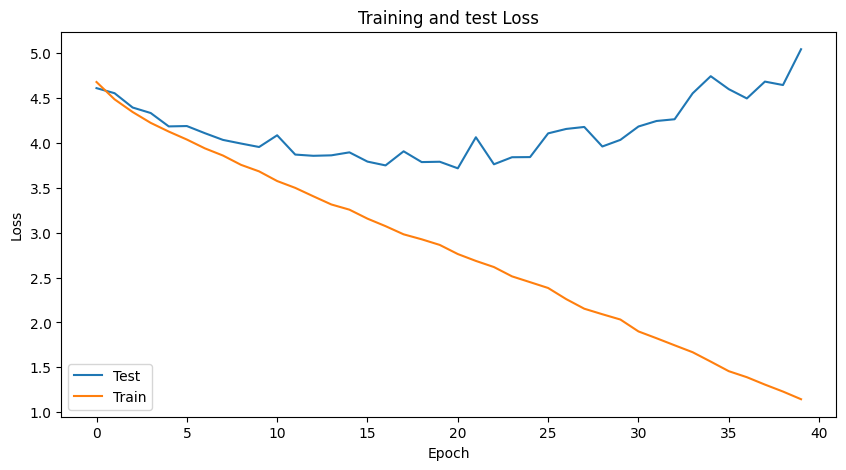

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and test Loss")
plt.plot(test_loss_list, label="Test")
plt.plot(train_loss_list, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Transfer learning from pre-trained weights

In [10]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=09acca417de1a2e278f7fd508292ce7870411b1c8706a5be54e5638ae93ff82c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


## Import dependency for EfficientNet model

In [11]:
from efficientnet_pytorch import EfficientNet

## Declare model
Note: The first step to transfer learning is to freeze all layers and later unfreeze the desired blocks (Only desired blocks will train).

In [12]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.efficientnet =  EfficientNet.from_pretrained('efficientnet-b0')
        # freeze all layers
        for p in self.efficientnet.parameters():
          p.requires_grad = False
        # Unfreeze last layer
        for param in self.efficientnet._fc.parameters():
          param.requires_grad = True
        for param in self.efficientnet._dropout.parameters():
          param.requires_grad = True

        self.efficientnet._dropout = nn.Sequential(nn.BatchNorm1d(1280), nn.Dropout(p=0.2, inplace=True))
        self.efficientnet._fc = nn.Linear(in_features=1280, out_features=120, bias=True)
        self.efficientnet._swish = nn.Identity()
    def forward(self, x):
        x = self.efficientnet(x)
        return x

## Creating an instance model

In [13]:
efficientnet_model = Classifier().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 164MB/s]


Loaded pretrained weights for efficientnet-b0


In [14]:
print(efficientnet_model)

Classifier(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePad

## Setting the loss function and optimizer

In [16]:
_optimizer = optim.Adam(params = efficientnet_model.parameters(), lr = LEARNING_RATE)
_criterion = nn.CrossEntropyLoss()

## Training Loop

In [17]:
# Training loop
train_loss_list_ft = []
test_loss_list_ft = []
train_acc_list_ft = []
test_acc_list_ft = []

NUM_EPOCHS_ft = 25
efficientnet_model.train()
for epoch in range(NUM_EPOCHS_ft):
    losses = 0
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for images, labels in tqdm(train_loader):
        # push images and labels to device to get CPU support
        images = images.to(device)
        labels = labels.to(device)
        predic_labels = efficientnet_model(images).to(device)
        # Zero the gradients
        _optimizer.zero_grad()
        # Forward pass
        loss = _criterion(predic_labels, labels)
        # Backward pass and optimization
        loss.backward()
        _optimizer.step()
        losses += loss.item()

        epoch_accuracy += ((predic_labels.argmax(dim=1) == labels.argmax(dim=1)).float().mean())
    epoch_loss = losses / len(train_loader)

    # Test the model
    efficientnet_model.eval()
    with torch.no_grad():
      test_losses = 0
      epoch_test_accuracy = 0.0
      epoch_test_loss = 0.0

      for data,label in test_loader:
        data = data.to(device)
        label = label.to(device)
        predic_testlabel = efficientnet_model(data).to(device)
        test_loss = _criterion(predic_testlabel, label)
        test_losses += test_loss.item()

        epoch_test_accuracy += ((predic_testlabel.argmax(dim=1) == label.argmax(dim=1)).float().mean())
    epoch_test_loss += test_losses/len(test_loader)
    ## loss data for Plot
    train_loss_list_ft.append(epoch_loss)
    test_loss_list_ft.append(epoch_test_loss)
    train_acc_list_ft.append(epoch_accuracy)
    test_acc_list_ft.append(epoch_test_accuracy)

    print('Epoch {}: , train accuracy: {}, train loss: {}, test_accuracy: {}, test_loss: {}'.format(epoch+1, epoch_accuracy / len(train_loader), epoch_loss, epoch_test_accuracy / len(test_loader), epoch_test_loss))


100%|██████████| 188/188 [01:52<00:00,  1.67it/s]


Epoch 1: , train accuracy: 0.3986037075519562, train loss: 2.480304993847583, test_accuracy: 0.5865354537963867, test_loss: 1.5036077274216546


100%|██████████| 188/188 [01:48<00:00,  1.73it/s]


Epoch 2: , train accuracy: 0.7015458345413208, train loss: 1.0430532069282328, test_accuracy: 0.6066743731498718, test_loss: 1.4346429802753307


100%|██████████| 188/188 [01:47<00:00,  1.74it/s]


Epoch 3: , train accuracy: 0.7598071694374084, train loss: 0.8219104559814676, test_accuracy: 0.6162808537483215, test_loss: 1.4690369323447898


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 4: , train accuracy: 0.7914727330207825, train loss: 0.6992977467623163, test_accuracy: 0.6074845194816589, test_loss: 1.5301940229203965


100%|██████████| 188/188 [01:47<00:00,  1.76it/s]


Epoch 5: , train accuracy: 0.814245343208313, train loss: 0.6186631345685493, test_accuracy: 0.6076002717018127, test_loss: 1.6160850959795492


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 6: , train accuracy: 0.8260471820831299, train loss: 0.5661960201377564, test_accuracy: 0.6084104776382446, test_loss: 1.649569895532396


100%|██████████| 188/188 [01:48<00:00,  1.74it/s]


Epoch 7: , train accuracy: 0.8457446694374084, train loss: 0.5085583215064191, test_accuracy: 0.599614143371582, test_loss: 1.7494077892215163


100%|██████████| 188/188 [01:47<00:00,  1.74it/s]


Epoch 8: , train accuracy: 0.8478224277496338, train loss: 0.4875461735782471, test_accuracy: 0.6002314686775208, test_loss: 1.8101855441376016


100%|██████████| 188/188 [01:48<00:00,  1.74it/s]


Epoch 9: , train accuracy: 0.8572971820831299, train loss: 0.45662253936554525, test_accuracy: 0.6027777791023254, test_loss: 1.8517767177687752


100%|██████████| 188/188 [01:47<00:00,  1.74it/s]


Epoch 10: , train accuracy: 0.8636967539787292, train loss: 0.4345610129864926, test_accuracy: 0.6012345552444458, test_loss: 1.9074832028812831


100%|██████████| 188/188 [01:48<00:00,  1.74it/s]


Epoch 11: , train accuracy: 0.8666887879371643, train loss: 0.41599088843832627, test_accuracy: 0.5978780388832092, test_loss: 1.9852554153513025


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 12: , train accuracy: 0.8676030039787292, train loss: 0.39764464717913184, test_accuracy: 0.5966048836708069, test_loss: 2.0322459245169604


100%|██████████| 188/188 [01:46<00:00,  1.76it/s]


Epoch 13: , train accuracy: 0.8809840083122253, train loss: 0.3699115828630772, test_accuracy: 0.595678985118866, test_loss: 2.070581743452284


100%|██████████| 188/188 [01:49<00:00,  1.72it/s]


Epoch 14: , train accuracy: 0.8846409320831299, train loss: 0.36106712902162935, test_accuracy: 0.5905863642692566, test_loss: 2.155991448296441


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 15: , train accuracy: 0.8873836398124695, train loss: 0.3571955558863726, test_accuracy: 0.5903549194335938, test_loss: 2.2285730997721354


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 16: , train accuracy: 0.8889627456665039, train loss: 0.34479894029333236, test_accuracy: 0.5897762179374695, test_loss: 2.2429686992256728


100%|██████████| 188/188 [01:48<00:00,  1.73it/s]


Epoch 17: , train accuracy: 0.8907911777496338, train loss: 0.3344802796602883, test_accuracy: 0.5901234149932861, test_loss: 2.2926176397888747


100%|██████████| 188/188 [01:48<00:00,  1.74it/s]


Epoch 18: , train accuracy: 0.8927027583122253, train loss: 0.32305624070478245, test_accuracy: 0.5932870507240295, test_loss: 2.3305397625322697


100%|██████████| 188/188 [01:47<00:00,  1.74it/s]


Epoch 19: , train accuracy: 0.897606372833252, train loss: 0.31496623372460936, test_accuracy: 0.5939428806304932, test_loss: 2.3800311821478384


100%|██████████| 188/188 [01:48<00:00,  1.73it/s]


Epoch 20: , train accuracy: 0.900182843208313, train loss: 0.30523595194074704, test_accuracy: 0.589313268661499, test_loss: 2.4146900362438624


100%|██████████| 188/188 [01:48<00:00,  1.73it/s]


Epoch 21: , train accuracy: 0.8961934447288513, train loss: 0.3105987289801557, test_accuracy: 0.5946758985519409, test_loss: 2.4276942168120983


100%|██████████| 188/188 [01:48<00:00,  1.73it/s]


Epoch 22: , train accuracy: 0.9007645845413208, train loss: 0.3089819483934565, test_accuracy: 0.5918595194816589, test_loss: 2.506521001568547


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 23: , train accuracy: 0.9038397073745728, train loss: 0.28949543960551, test_accuracy: 0.5901234149932861, test_loss: 2.5511877550019157


100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


Epoch 24: , train accuracy: 0.9060006141662598, train loss: 0.2816934517010095, test_accuracy: 0.5880401134490967, test_loss: 2.5840593108424432


100%|██████████| 188/188 [01:46<00:00,  1.77it/s]


Epoch 25: , train accuracy: 0.9069979786872864, train loss: 0.2912866368572763, test_accuracy: 0.5845678448677063, test_loss: 2.592592206707707


## Plot Loss of train and test data
Note: The test accuracy and loss will usually be better than training accuracy. This is because the regularization is strong, which only suppresses training-time metrics.


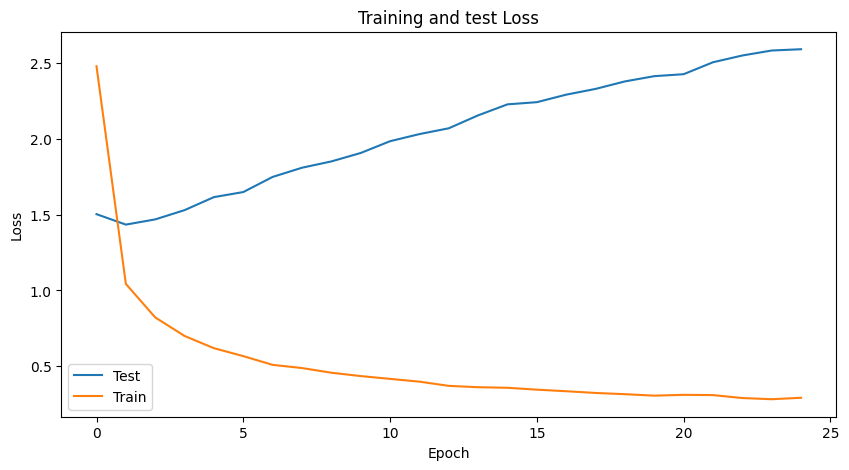

In [18]:
plt.figure(figsize=(10,5))
plt.title("Training and test Loss")
plt.plot(test_loss_list_ft, label="Test")
plt.plot(train_loss_list_ft, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()